This notebook primarily serves as an exploratory analysis of our data set. We
- load, clean, and format the data from a CSV,
- explore the relationship between insider trade occurrence and ticker price change soon thereafter,
- explore the relationship between volume leading up to a trade and eventual price change, and
- visualize some examples of ticker data with insider trades overlaid.

In [1]:
import yfinance as yf
import pandas as pd
import os
import datetime as dt
import pickle
import numpy as np
import copy
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

### A Few Important Functions

In [89]:
def save_obj(obj, name):
    '''
    Save data as a pickle object.
    '''
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    '''
    Load pickled data.
    '''
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def validate(date_text):
    '''
    Ensure that all dates have a valid format.
    '''
    try:
        dt.datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")
        
def getHistoricDat_date(ticks, min_dt, max_dt):
    '''
    Download stock data from the Yahoo Finance API between two dates.
    '''
    validate(min_dt)
    validate(max_dt)
    
    historicDat = {}
    
    for t in ticks:
        stockDat = yf.download(t, 
                               start=min_dt, 
                               end=max_dt, 
                               progress=False
                              )
        historicDat[t] = stockDat
        print(str(len(historicDat))+'/'+str(len(ticks)) + ' done', end='\r')
    return historicDat

### Clean and Format the Data

In [91]:
def cleanAndFormatDF(csv_loc, clean_csv_loc, historicDat_loc, newORload='load', startDate=None, endDate=None):
    insiderDat = pd.read_csv(csv_loc + '.csv')

    insiderDat = insiderDat.rename(columns={'Filing Date': 'FilingDate', 
                                            'Trade Date': 'TradeDate', 
                                            'Company Name': 'CompanyName', 
                                            'Insider Name': 'InsiderName', 
                                            'Trade Type': 'TradeType'},
                                   errors='raise')

    # NOTE: I am stripping away the filing date's time; assume we can't buy until opening next day
    # https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
    insiderDat.FilingDate = [dt.datetime.strptime(str(r), '%Y-%m-%d %H:%M:%S').date() for r in insiderDat.FilingDate]
    insiderDat.TradeDate = [dt.datetime.strptime(str(r), '%Y-%m-%d').date() for r in insiderDat.TradeDate]
    insiderDat.Ticker = ['NA' if 'Cardinal Ethanol LLC' in t[1] else t[0] 
                         for t in zip(insiderDat.Ticker, insiderDat.CompanyName)]
    insiderDat = insiderDat.replace({'Ticker': {'FB': 'META'}})
    insiderDat.Price = [float(p.replace(',','').replace('$','')) for p in insiderDat.Price]
    insiderDat.Qty = [float(q[1]) if '#' in q[0] else float(q[0].replace(',','')) 
                      for q in zip(insiderDat.Qty, insiderDat.Qty2)]
    insiderDat.Owned = [float(o.replace(',','')) for o in insiderDat.Owned]

    insiderDat = insiderDat.replace({'DeltaOwn': {'New': '999999'}})
    insiderDat = insiderDat.replace({'DeltaOwn': {'>999%': '999999'}})
    insiderDat.DeltaOwn = [float(d.replace('%','')) for d in insiderDat.DeltaOwn]
    insiderDat = insiderDat.replace({'DeltaOwn': {'999999': 10*max(insiderDat.DeltaOwn)}})
    insiderDat.Value = [float(v[1]) if '#' in v[0] else float(v[0].replace(',','').replace('$','')) 
                        for v in zip(insiderDat.Value, insiderDat.Value2)]
    insiderDat = insiderDat.sort_values(by='FilingDate').reset_index().drop('index', axis=1)
    
    
    
    allTickers = insiderDat.Ticker.unique()
    print('There are ' + str(len(allTickers)) + ' unique tickers.\nGetting historic data for these tickers...')
    
    if newORload == 'new':
        historicDat = getHistoricDat_date(allTickers, startDate, endDate)
        save_obj(historicDat, historicDat_loc)
    elif newORload == 'load':
        historicDat = load_obj(historicDat_loc)
    else:
        raise ValueError('newORload must be ''new'' or ''load''')
        
        
    exampleTick = next(iter(historicDat))
    print(f'\nExample ticker data for {exampleTick}:')
    print(historicDat[exampleTick])
    
    
    '''Now we want to remove trades for tickers that no longer exist.'''
    
    ghostTickers = set()

    for tick in allTickers:
        if historicDat[tick].empty:
            ghostTickers.add(tick)

    insiderDat = insiderDat[insiderDat.Ticker.isin(ghostTickers)==False]
    insiderDat = insiderDat.drop(['Qty2', 'Value2'], axis=1).reset_index()
    insiderDat = insiderDat.drop(['index'], axis=1)

    allUniqueTickers = insiderDat.Ticker.unique()
    print('\nAfter filtering, there are ' + str(len(allUniqueTickers)) + ' tickers.')
    
    
    '''For convenience, we also want to remove trades for tickers that were listed after our start date.'''
    newTickers = set()
    for tick in allUniqueTickers:
        if historicDat[tick].index[0] > dt.datetime.strptime(startDate, '%Y-%m-%d'):
            newTickers.add(tick)

    print(f'\nThere are {len(newTickers)} tickers that were listed on an exchange after {startDate}.')
    
    insiderDat = insiderDat.loc[insiderDat['Ticker'].isin(newTickers) == False]
    
    insiderDat.to_csv(clean_csv_loc + '.csv', index=False)
    print('Here is the top of our cleaned dataframe of trades:\n')
    print(insiderDat.head())
    
    return insiderDat, historicDat

In [88]:
insiderDat, historicDat = cleanAndFormatDF('data/sec4_June', 'data/insiderDat_June_clean', 'data/historicDat', 
                                           newORload='new', startDate='2021-06-01', endDate='2022-06-01')

There are 1795 unique tickers.
Getting historic data for these tickers...
17/1795 done
1 Failed download:
- NTUS: No data found, symbol may be delisted
34/1795 done
1 Failed download:
- MOGA.: No data found, symbol may be delisted
45/1795 done
1 Failed download:
- INOV: No data found, symbol may be delisted
55/1795 done
1 Failed download:
- EMPR: No data found, symbol may be delisted
74/1795 done
1 Failed download:
- RRD: No data found, symbol may be delisted
82/1795 done
1 Failed download:
- PMBC: No data found, symbol may be delisted
84/1795 done
1 Failed download:
- MSP: No data found, symbol may be delisted
94/1795 done
1 Failed download:
- BFIIW: No data found for this date range, symbol may be delisted
106/1795 done
1 Failed download:
- NA: Data doesn't exist for startDate = 1622520000, endDate = 1654056000
120/1795 done
1 Failed download:
- PSTI: No data found, symbol may be delisted
132/1795 done
1 Failed download:
- GTXMQ: No data found, symbol may be delisted
161/1795 done
1 

In [7]:
SP500Dat = getHistoricDat_date(['SPY'], '2021-06-01', '2022-06-01')
save_obj(SP500Dat, 'SP500Dat')
#load_obj('SP500Dat')

In [13]:
def returnDataOnDate(historicDat, tick, startDate, delta=0, dataName='Close', searchDirection=1):
    '''
    Given a start date, return tick's 'val' associated with 'dataName', 'delta' days later. In the event that the 
    stock market was not open on this future date, function returns the nearest viable date in the 
    direction of 'searchDirection', looking forward or backward one day at a time.
    
    IN:
        -historicDat (dict)
        -tick (str)
        -startDate (str): %Y-%m-%d
        -delta (int)
        -dataName (str): 'Open', 'Close', 'Volume', etc
        -searchDirection (int): either +1 or -1
    OUT:
        -val (float)
        -futureDate (date object)
    '''
    
    futureDate = dt.date.strftime(dt.datetime.strptime(startDate, '%Y-%m-%d') 
                                           + dt.timedelta(days=delta), '%Y-%m-%d')
    
    e = 'KeyError'
    while e == 'KeyError':
        try:
            val = historicDat[tick].loc[futureDate][dataName]
            e = 'No Error'

        except KeyError:
            futureDate = dt.date.strftime(dt.datetime.strptime(futureDate, '%Y-%m-%d') 
                                               + dt.timedelta(days=searchDirection), '%Y-%m-%d')
            if dt.datetime.strptime(futureDate, '%Y-%m-%d') < dt.datetime.strptime('2021-06-01', '%Y-%m-%d'):
                raise ValueError('Out-of-bounds date caused by ' + tick + ' on ' + startDate)
            
    return val, dt.datetime.strptime(futureDate, '%Y-%m-%d').date()

In [14]:
def returnPriceDiff(insiderDat, historicDat, SP500Dat, delta, priceTime):
    '''
    Returns difference between price at 'priceTime' on the initial filing date and price at 'priceTime',
    'delta' days later for each ticker in 'historicDat'.
    
    IN:
        -insiderDat (pd.DataFrame)
        -historicDat (dict): maps ticker name (str) to ticker data (pd.DataFrame)
        -SP500Dat (dict): maps ticker name (str) to ticker data (pd.DataFrame)
        -delta (int)
        -priceTime (str): 'Open', 'Close'
    OUT:
        -closingDiff (dict): maps trade (str) to % price difference for ticker and S&P500 (float, float)
    '''
    
    closingDiff = {}
    
    for tradeNum, trade in insiderDat.iterrows():
        tick = trade['Ticker']
        
        startDate = str(trade['FilingDate'])
        
        startPrice, _ = returnDataOnDate(historicDat, tick, startDate, dataName=priceTime, searchDirection=-1)
        futurePrice, _ = returnDataOnDate(historicDat, tick, startDate, dataName=priceTime, delta=delta)
        startPrice_SP500, _ = returnDataOnDate(SP500Dat, 'SPY', startDate, dataName=priceTime, searchDirection=-1)
        futurePrice_SP500, _ = returnDataOnDate(SP500Dat, 'SPY', startDate, dataName=priceTime, delta=delta)
        
        closingDiff[tick + str(tradeNum)] = (100*(futurePrice - startPrice) / startPrice, 
                                             100*(futurePrice_SP500 - startPrice_SP500) / startPrice_SP500)

    return closingDiff

In [15]:
EODayPrice = returnPriceDiff(insiderDat, historicDat, SP500Dat, delta=1, priceTime='Close')

EOWeekPrice = returnPriceDiff(insiderDat, historicDat, SP500Dat, delta=7, priceTime='Close')

EOMonthPrice = returnPriceDiff(insiderDat, historicDat, SP500Dat, delta=30, priceTime='Close')

EO3MonthPrice = returnPriceDiff(insiderDat, historicDat, SP500Dat, delta=90, priceTime='Close')

In [16]:
print('(% change in ticker price, % change in S&P500):')
EOMonthPrice['CMBM0']

(% change in ticker price, % change in S&P500):


(-16.886954929517664, 2.563914243041266)

In [105]:
from random import random

def createDifferencePlots(diffDat, delta, thresh):
    tickPrices = [val[0] for val in diffDat.values()]
    SP500Prices = [val[1] for val in diffDat.values()]
    
    fig, ax = plt.subplots(1, 1)
    ax.plot(diffDat.keys(), tickPrices, '.b', markersize=8)
    ax.plot(diffDat.keys(), SP500Prices, '--r', label='S&P500')
    ax.set_xticklabels([])
    
    for key in diffDat.keys():
        if (abs(diffDat[key][0]) > thresh) and random() < 0.25:
            ax.annotate(key, (key, diffDat[key][0]))
    
    plt.xticks([])
    plt.xlabel(f'({len(diffDat)} Trades)')
    plt.ylabel(f'% difference in price after {delta} days')
    #plt.yscale('symlog')
    plt.title(f'Stock price percentage difference after insider buy: {delta} days later')
    plt.legend()
    plt.show()
    
    #mplcursors.cursor(multiple = True).connect(
    #    "add", lambda sel: sel.annotation.set_text(diffDat.keys()[sel.target.index]))

    diffDat_filtered = [v for v in diffDat.values() if v is not None]
    print(f'The mean increase is {np.mean(diffDat_filtered)}%.')
    print(f'The standard deviation is {np.std(diffDat_filtered)}%.')

### Here we visualize the distribution of changes in price after insider trades.

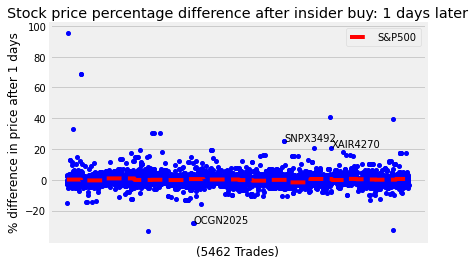

The mean increase is 0.16812670191845247%.
The standard deviation is 2.8488228585993363%.


In [106]:
createDifferencePlots(EODayPrice, delta=1, thresh=20)

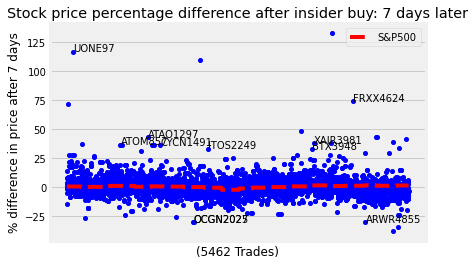

The mean increase is 0.6039100086929385%.
The standard deviation is 5.256927542710423%.


In [107]:
createDifferencePlots(EOWeekPrice, delta=7, thresh=30)

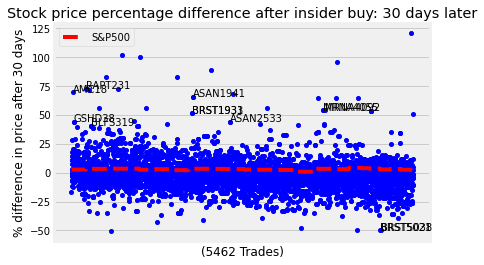

The mean increase is 0.4828866530614808%.
The standard deviation is 9.256202242127106%.


In [108]:
createDifferencePlots(EOMonthPrice, delta=30, thresh=40)

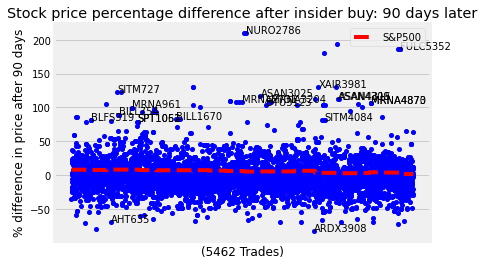

The mean increase is 2.402469840717676%.
The standard deviation is 17.49484979093355%.


In [110]:
createDifferencePlots(EO3MonthPrice, delta=90, thresh=70)

#### Notice that there are many outliers above and below the "band" in each plot.

Let's look into the price trends of only those tickers that experienced qualitatively-outlying changes; say, +/- 20% after one day, +/- 30% after one week, +/- 40% after one month, and +/- 70% after 3 months.

In [72]:
'''
In this cell, we gather together the price futures of trades that experienced an outlying price jump 
within a given period after an insider trade. The thresholds are determined by 'increaseThresh'.
'''

days2lookForward = 90

# 1 day, 1 week, 1 month, 3 months
increaseThresh = [20, 30, 40, 70]

EO_Prices = [EODayPrice, EOWeekPrice, EOMonthPrice, EO3MonthPrice]
numCharts = len(increaseThresh)

outlierClosings_up = [np.full((1,days2lookForward), np.nan)]*numCharts
outlierClosings_down = [np.full((1,days2lookForward), np.nan)]*numCharts

for tradeNum, trade in insiderDat.iterrows():
    tick = trade['Ticker']
    tradeName = tick + str(tradeNum)
    fileDate = str(trade['FilingDate'])

    # if the trade's ticker changes by a sufficient amount, store its daily closing for the next 
    # 'days2lookForward' days    
    for i in range(numCharts):
        if abs(EO_Prices[i][tradeName][0]) > increaseThresh[i]:
            newCol = np.full((1,days2lookForward), np.nan)
            startingPrice, _ = returnDataOnDate(historicDat, tick, fileDate, delta=0)
            for d in range(days2lookForward):
                closingPrice, _ = returnDataOnDate(historicDat, tick, fileDate, delta=d)
                newCol[0,d] = 100*(closingPrice-startingPrice)/startingPrice

            if EO_Prices[i][tradeName][0] > increaseThresh[i]:
                outlierClosings_up[i] = np.append(outlierClosings_up[i], newCol, axis=0)
            else:
                outlierClosings_down[i] = np.append(outlierClosings_down[i], newCol, axis=0)

In [76]:
def createOutlyingDifferencePlots(outlierClosings_up, outlierClosings_down):
    fig, ax = plt.subplots(1, 1)
    for row in outlierClosings_up:
        ax.plot(list(range(outlierClosings_up.shape[1])), row, '-b', markersize=6)
    for row in outlierClosings_down:
        ax.plot(list(range(outlierClosings_down.shape[1])), row, '-r', markersize=6)
    #ax.legend()
    #ax.set_xticklabels([])
    
    #plt.xticks([])
    plt.xlabel(f'(Days after Trade)')
    plt.ylabel(f'% difference from original price')
    #plt.legend('initial increase', 'initial decrease')
    #plt.yscale('symlog')
    plt.title(f'Outlying stock price percentage differences after insider trade')
    plt.show()

### Here, we focus on price trends for only those tickers that achieve outlying results.

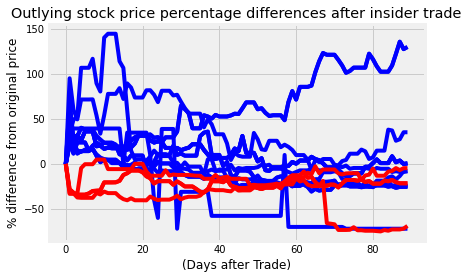

Closing prices for stocks that rose (blue) or fell (red) by at least 20% within ONE day of the filing date.


In [77]:
createOutlyingDifferencePlots(outlierClosings_up[0], outlierClosings_down[0])
print('Closing prices for stocks that rose (blue) or fell (red) by at least 20% within ONE day \
of the filing date.')

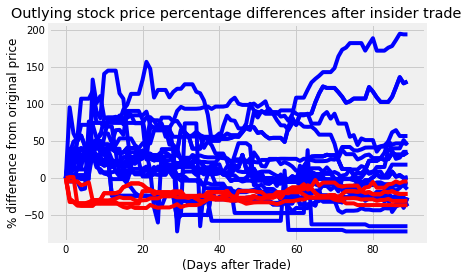

Closing prices for stocks that rose (blue) or fell (red) by at least 30% within SEVEN days of the filing date.


In [78]:
createOutlyingDifferencePlots(outlierClosings_up[1], outlierClosings_down[1])
print('Closing prices for stocks that rose (blue) or fell (red) by at least 30% within SEVEN days \
of the filing date.')

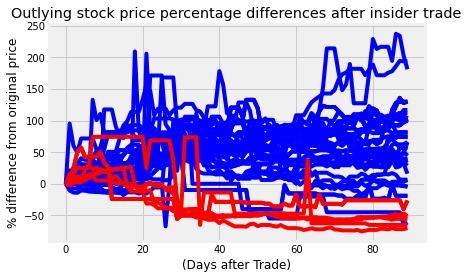

Closing prices for stocks that rose (blue) or fell (red) by at least 40% within THIRTY days of the filing date.


In [79]:
createOutlyingDifferencePlots(outlierClosings_up[2], outlierClosings_down[2])
print('Closing prices for stocks that rose (blue) or fell (red) by at least 40% within THIRTY days \
of the filing date.')

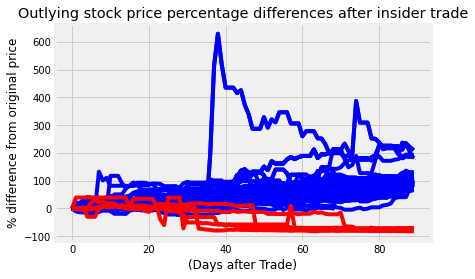

Closing prices for stocks that rose (blue) or fell (red) by at least 70% within NINETY days of the filing date.


In [80]:
createOutlyingDifferencePlots(outlierClosings_up[3], outlierClosings_down[3])
print('Closing prices for stocks that rose (blue) or fell (red) by at least 70% within NINETY days \
of the filing date.')

It appears that, for the most part, outlying upward price jumps tend to occur within at most a few days of the filing date. However, for prices that **stay** outlying a month or more after the filing, these jumps seem to happen more gradually. I have a hunch that we'll be able to learn this behavior more easily!

Outlying downward price jumps seem to hold or continue downwards. However, we see a few examples of volatile stocks that significantly gained initially before eventually plummeting at the end of the month -- we want to capture that intial upward behavior and then sell!

It seems to make sense to predict the **best** future percentage price increase that we expect to see in the next X days. The question is, **what should X be?**

Initially I was tempted to make X small in the hope of capturing immediate gainers and have a shorter-term strategy. However, this will miss out on longer-term gainers. And if we do let X be large, and the highest gain is achieved after only a few days, then great! The model will hopefully predict that the price will jump **sometime** in the next large period of time, and we'll be able to sell when that happens.

Let's choose X=90 for now. We will also look back 1 day for things like volume change and counting recent same-ticker trades.

In [28]:
DAYS_TO_LOOK_FORWARD = 90
DAYS_TO_LOOK_BACK = 1

Now we should explore a few other things of interest, namely
- the number of same-ticker trades filed in the previous few days,
- the change in volume over the previous few days.

In [29]:
def returnVolumeAndPriceChange(historicDat, tick, fileDate, daysToLookForward, daysToLookBack):
    currentVol, dateUsed = returnDataOnDate(historicDat, tick, dt.date.isoformat(fileDate), 
                                            dataName='Volume', searchDirection=-1)
    
    previousVol, prevDateUsed = returnDataOnDate(historicDat, tick, 
                                      dt.date.isoformat(dateUsed-dt.timedelta(days=daysToLookBack)), 
                                      dataName='Volume', searchDirection=-1)
    if previousVol == 0 and currentVol == 0:
        percentChangeVol = 0
    elif previousVol == 0:
        percentChangeVol = 9999
    else:          
        percentChangeVol = 100*(currentVol-previousVol) / previousVol
    
    
    currentPrice = historicDat[tick].loc[dt.date.isoformat(dateUsed)]['Close']
    
    highestPrice = 0
    for i in range(1, daysToLookForward):
        tempPrice, _ = returnDataOnDate(historicDat, tick, dt.date.isoformat(dateUsed), delta=i)
        if tempPrice > highestPrice:
            highestPrice = tempPrice
            
    percentChangePrice = 100*(highestPrice-currentPrice) / currentPrice
    
    return percentChangeVol, percentChangePrice
        

def createVolumePriceScatters(volPriceDat):
    fig, ax = plt.subplots(1, 1)
    ax.plot([val[0] for val in volPriceDat], [val[1] for val in volPriceDat], '.b', markersize=8)
    
    plt.xlabel(f'% Change in Volume in Previous {DAYS_TO_LOOK_BACK} Days')
    plt.ylabel(f'% Change in Closing Price in Next {DAYS_TO_LOOK_FORWARD} Days')
    plt.xscale('symlog')
    plt.title(f'Price Change vs Volume Change')
    plt.show()

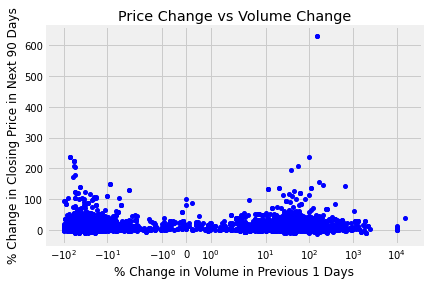

In [30]:
'''Plot the relationship between max price change in the next 3 months vs most recent change in volume.'''

startDate = dt.datetime.strptime('2021-06-01', '%Y-%m-%d').date()

volPriceDat = []
for tradeNum, trade in insiderDat.iterrows():
    tick = trade['Ticker']
    fileDate = trade['FilingDate']
    
    # skip the first DAYS_TO_LOOK_BACK days so we have data to look back at
    if (fileDate - dt.timedelta(days=DAYS_TO_LOOK_BACK)) < startDate:
        continue
    
    volPriceDat.append(returnVolumeAndPriceChange(historicDat, tick, fileDate, 
                                                  DAYS_TO_LOOK_FORWARD, DAYS_TO_LOOK_BACK))

createVolumePriceScatters(volPriceDat)

The volume losers and gainers are clearly split into two camps on the semilog plot.

Notice that most large price changes (at least +/- 20%) are associated with larger volume changes (at least +/- 10%).

Finally, let's take a closer look at some of the bigger price movements relative to when a trade was made.

In [31]:
insiderDat.Ticker.value_counts()

CONN    78
ZI      51
CRC     45
ZIP     41
CVNA    33
        ..
AGR      1
WCN      1
PYPL     1
XXII     1
CALX     1
Name: Ticker, Length: 1655, dtype: int64

In [96]:
def plotPriceWithTrades(historicDat, tick, insiderDat):
    insiderDat.TradeDate = [np.datetime64(td) for td in insiderDat.TradeDate]
    insiderDat.FilingDate = [np.datetime64(td) for td in insiderDat.FilingDate]
    groups = insiderDat.groupby('TradeType')
    
    historicDat_Jun = pd.DataFrame(columns=historicDat[tick].columns, index=historicDat[tick].index)
    historicDat_Jun = historicDat_Jun.astype(float)
    for d in pd.date_range(start='2021-06-01', end='2021-06-30'):
        try:
            historicDat_Jun.loc[d] = historicDat[tick].loc[d]
        except KeyError:
            pass
    
    historicDat_Jun = historicDat_Jun.dropna()
    
    fin_av = [(historicDat_Jun.High[i] + historicDat_Jun.Low[i])/2 for i in range(len(historicDat_Jun))]

    fig, ax = plt.subplots()
    ax.plot(historicDat_Jun.index, fin_av)
    ax.fill_between(historicDat_Jun.index, historicDat_Jun.Low, historicDat_Jun.High, color='b', alpha=.1)
    cmap = {'P - Purchase': 'g', 'S - Sale': 'r', 'S - Sale+OE': 'y'}
    for name, group in groups:
        #ax.plot(group.TradeDate, group.Price, marker='o', linestyle='', label=name)
        ax.plot(group.FilingDate, group.Price, marker='o', linestyle='', label=name+', filed', color=cmap[name])
    ax.legend()
    
    plt.xticks(rotation=45)
    plt.title(tick + ' price in June')

In [33]:
import warnings
warnings.filterwarnings('ignore')

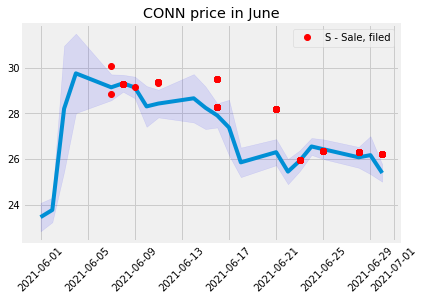

In [97]:
plotPriceWithTrades(historicDat, 'CONN', insiderDat[insiderDat.Ticker == 'CONN'])

CONN has the most trades in the given time period, with 78! Notice that there had just been a big price run-up, so insiders were likely selling for short-term profit.

For our purposes, nothing about these sales is probably very helpful -- they are more indicative of the past event rather than the future.

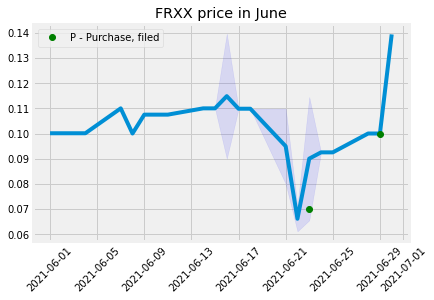

In [98]:
plotPriceWithTrades(historicDat, 'FRXX', insiderDat[insiderDat.Ticker == 'FRXX'])

FRXX is an interesting one. The insider(s) made that first purchase the day before and caught that upward price trend, but we wouldn't be able to take advantage with the filing occurring the day after.

However, the second filing occurred just in time to be able to catch the second price jump!

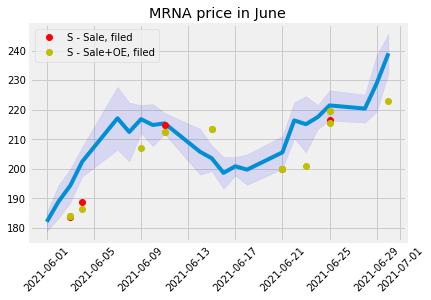

In [111]:
plotPriceWithTrades(historicDat, 'MRNA', insiderDat[insiderDat.Ticker == 'MRNA'])

And here's Moderna. We all know their success story in the past couple of years, so something tells me that all of these sales are not very indicative of future price action. That's something worth considering in the modeling process.